# Prerequisites

## Dependencies

In [209]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2 as cv
import numpy as np

from cleanvision import Imagelab

In [176]:
FIGSIZE=(16,9)

## Dataset

In [177]:
df = pd.read_csv("Dataset/meta_train.csv")
df_original = df.copy()

df.head()

,image_id,label,variety,age
0,100330.jpg,bacterial_leaf_blight,ADT45,45
1,100365.jpg,bacterial_leaf_blight,ADT45,45
2,100382.jpg,bacterial_leaf_blight,ADT45,45
3,100632.jpg,bacterial_leaf_blight,ADT45,45
4,101918.jpg,bacterial_leaf_blight,ADT45,45


# Exploratory Data Analysis

## Metadata and Images Validation

At the very first step of analysing the dataset, make sure every entry of the metadata has its image and vice versa.

In [178]:
import glob
# get all image files, remove directy and save as literal definition (label/image_id)
images = [tuple(f.replace("Dataset/train_images/", "").split("/")) for f in glob.glob("Dataset/train_images/*/*.jpg")]

images_df = pd.DataFrame.from_records(images, columns=["label", "image_id"])

# number of images over number of metadata
print(f"{len(images)} images/{df.shape[0]} metadata")

# verify label + image_id equals original dataset
images_df.sort_values(by=["label", "image_id"]).reset_index()[["label", "image_id"]].equals(df.sort_values(by=["label", "image_id"]).reset_index()[["label", "image_id"]])

10407 images/10407 metadata


True

After verifying through occurences of images and label, check if there is any missing values in metadata.

In [179]:
df.isnull().sum()

image_id    0
label       0
variety     0
age         0
dtype: int64

Here, metadata has no missing values.

## Statistical Overview

After simple data validation, the type of data and further statistical analysis could then be performed on both the metadata and images dataset.

In [180]:
df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
image_id,10407,10407,110381.jpg,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
label,10407,10,normal,1764,NaN,NaN,NaN,NaN,NaN,NaN,NaN
variety,10407,10,ADT45,6992,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,10407.0,NaN,NaN,NaN,64.043624,8.95883,45.0,60.0,67.0,70.0,82.0


For metadata dataset, there are 10 unique label types and 10 variety types, with age being in a considerable range of 45 to 82. With that, this data could be categorized into **categorical** (finite number of known values) and **discrete** (numeric in a range of values) feature types, where variety and label being limited - thus **categorial**, and age being **discrete** as it is countable.

### Data Shapes

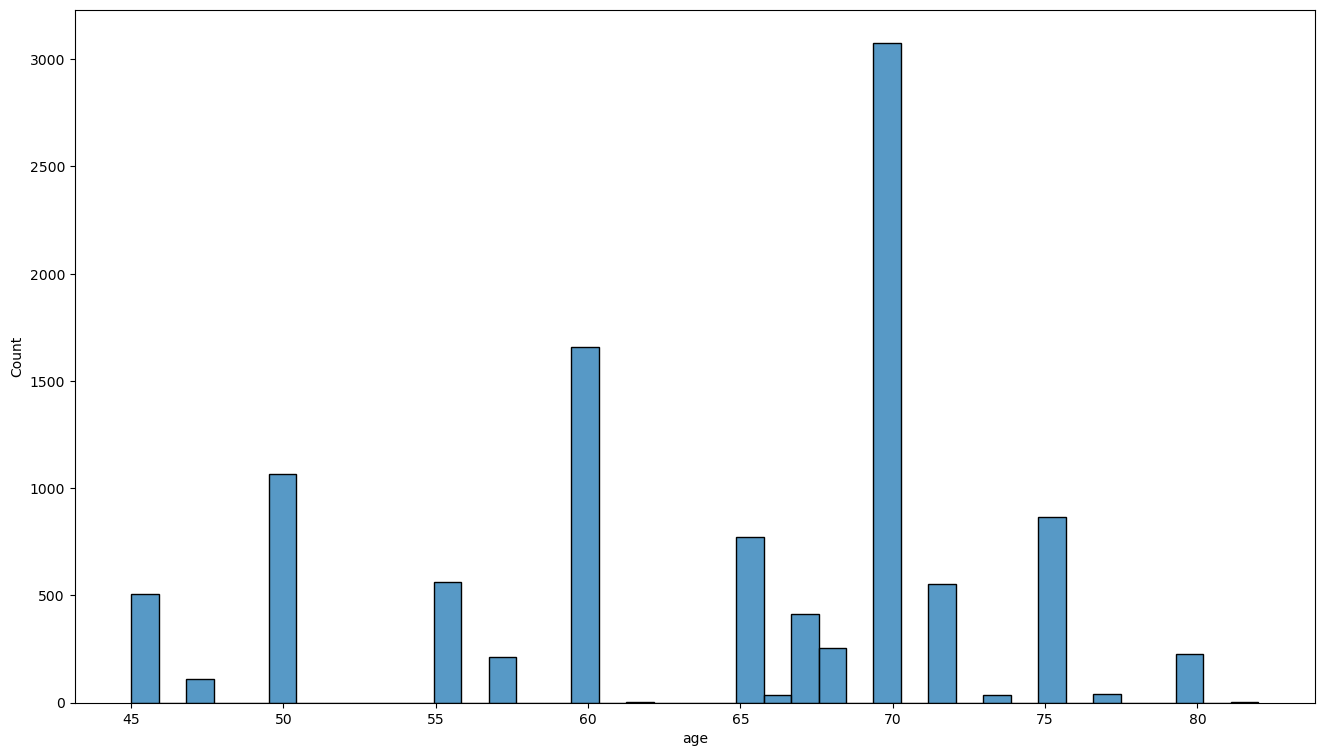

In [181]:
plt.figure(figsize=FIGSIZE)
sns.histplot(data=df, x="age")
plt.show()

First, visualizing age as a **discrete** feature, it has a fairly Gaussian-like distribution, with most values ranging from 60-70, and a noticable dip at ~50-55 and ~60-65.

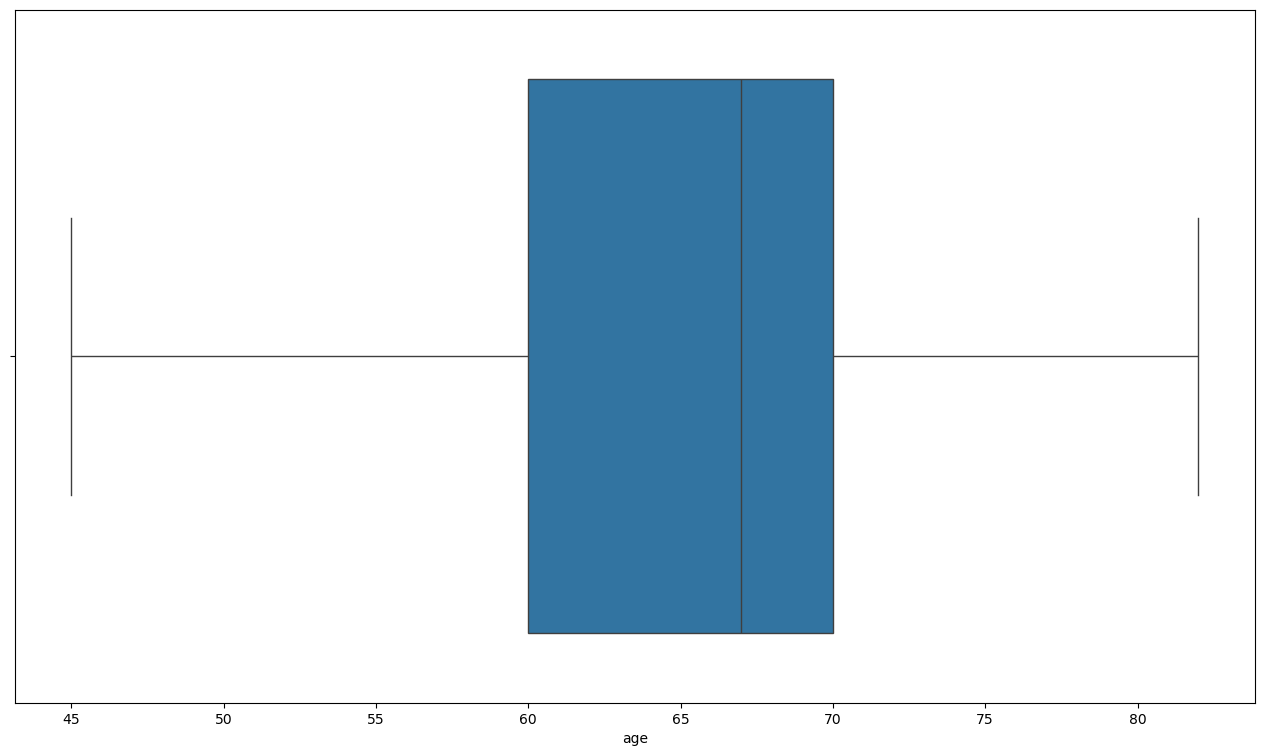

In [182]:
plt.figure(figsize=FIGSIZE)
sns.boxplot(data=df, x='age')
plt.show()

To further demonstrate, age distributed quite well with no outliers found, and its interquartile range both meets the lower and higher range of the data.

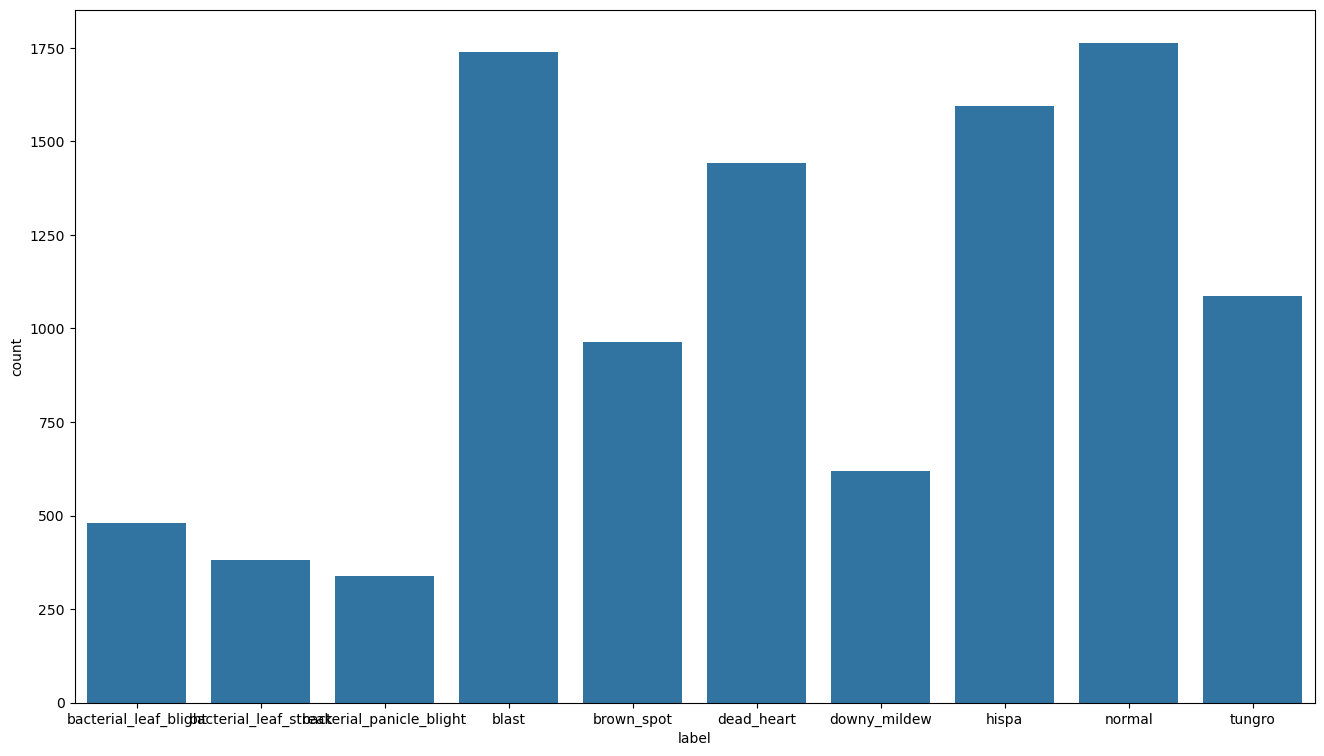

In [183]:
plt.figure(figsize=FIGSIZE)
sns.countplot(data=df, x='label')
plt.show()

Upon looking at the number of disease labels, about half of the dataset has high and mostly equal contribution to the dataset, while other contributes worse. This could be further normalize to improves the quality and balance of the model to make it generalize better.

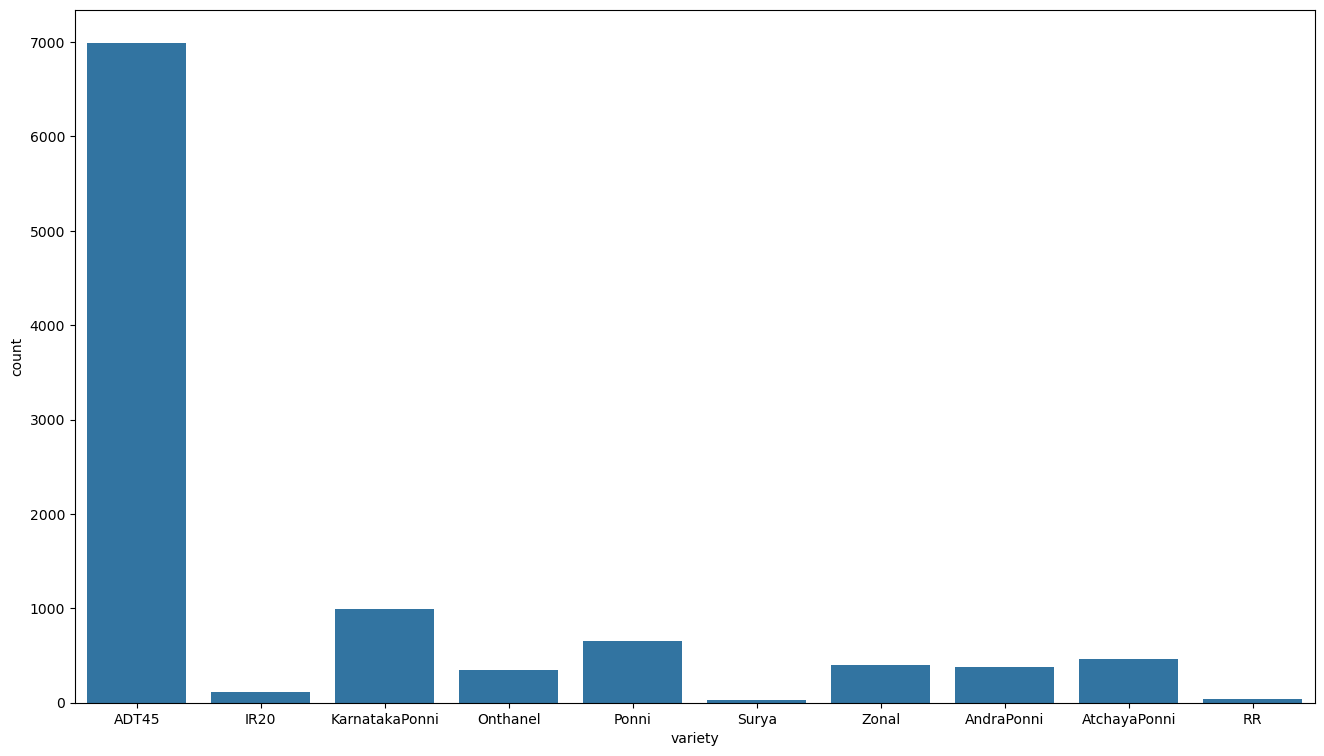

In [184]:
plt.figure(figsize=FIGSIZE)
sns.countplot(data=df, x='variety')
plt.show()

However with the variety of contributing plant of the dataset, `ADT45` is the majority with almost ~7000/10400 images, gaining 67% contribution of all plant types. Here, `RR`, `Surya` and `IR20` has the least data contribution to the dataset.

### Relationships Between Features

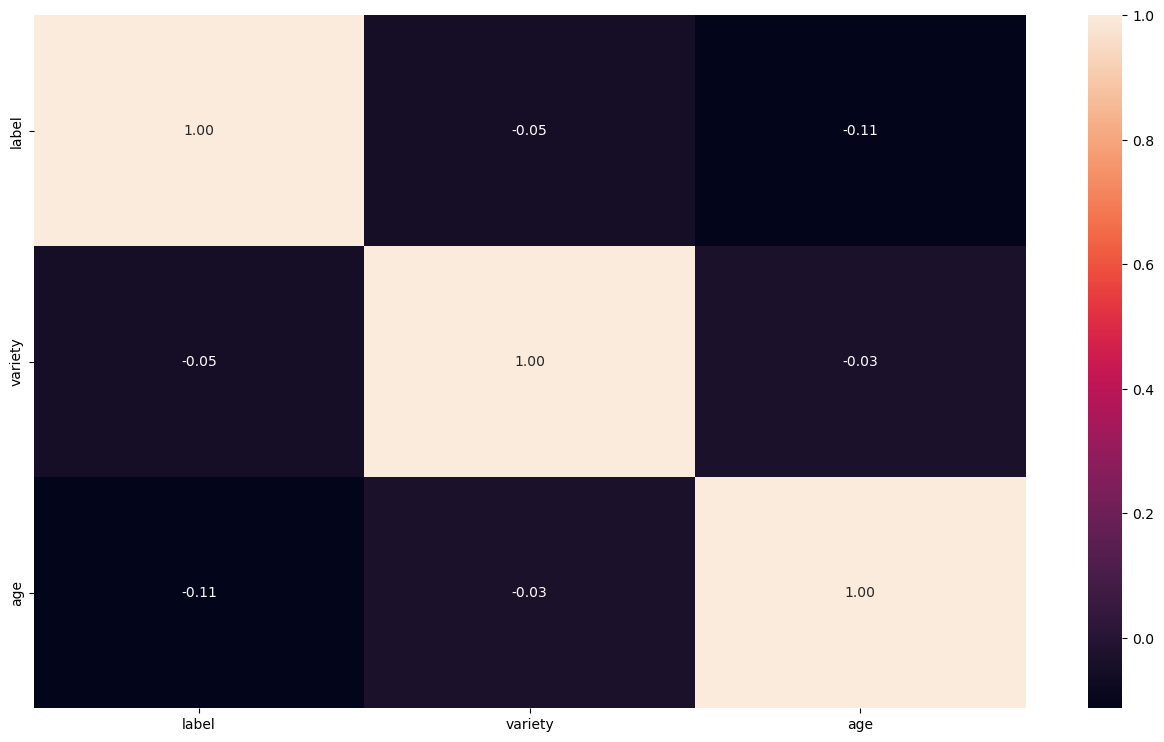

In [185]:
plt.figure(figsize=FIGSIZE)
corr = df.drop("image_id", axis=1).apply(lambda x : pd.factorize(x)[0]).corr(method='pearson', min_periods=1)
sns.heatmap(corr, annot=True, fmt=".2f")
plt.show()

Factorize categorial values and plot correlation heatmap to show relationship between features, it is saw that the features correlate quite poorly, as correlation values variate between the 0 mark.

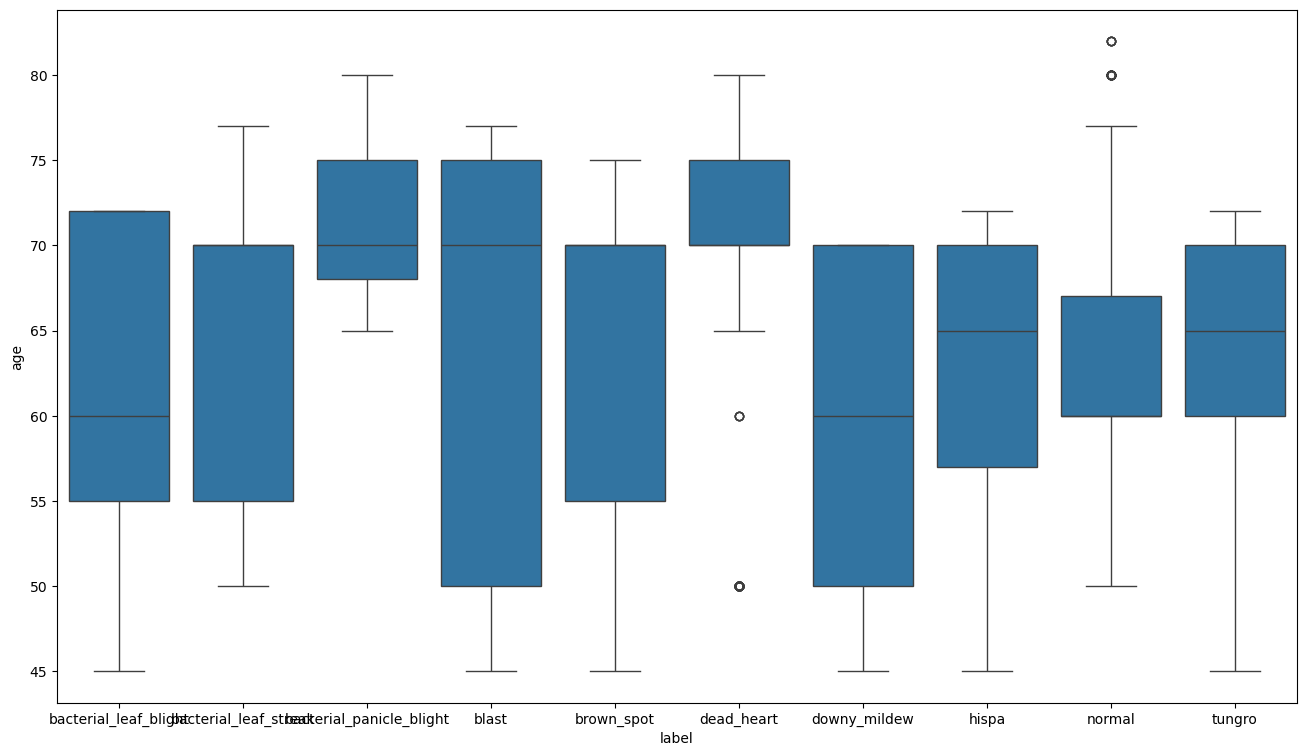

In [186]:
plt.figure(figsize=FIGSIZE)
sns.boxplot(data=df, x='label', y='age')
plt.show()

When compare age to disease label, unhealthy labels tend to has larger interquartile range, while health (`normal`) label variate in between 60-67. Here, small amount of outliers could be seen to contribute to the dataset.

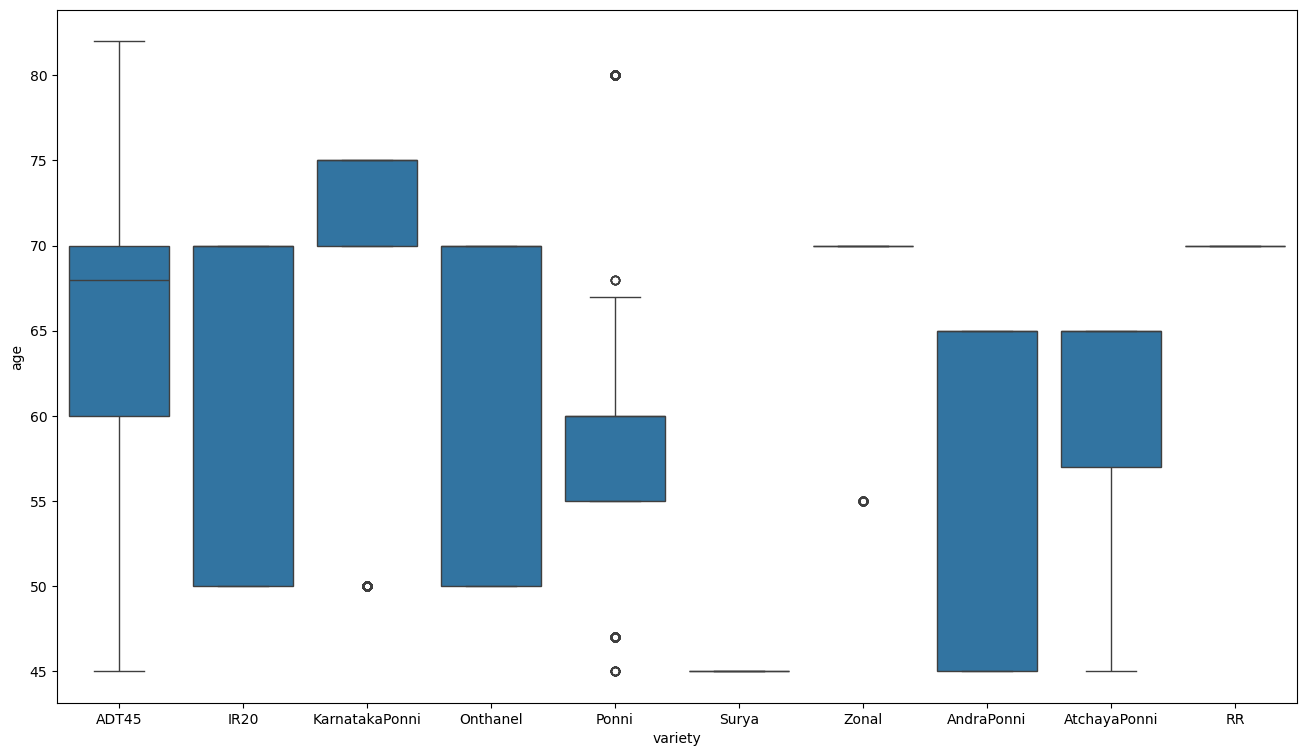

In [187]:
plt.figure(figsize=FIGSIZE)
sns.boxplot(data=df, x='variety', y='age')
plt.show()

However when compare age to variety, `ADT45` has more distributed data with the interquartile range in 60-70, while other variety such as `Surya`, `RR` and `Zonal` are found to has only one age value, and others has more "controlled" values. This aligns well with earlier founding of least data contribution to the dataset of following features.

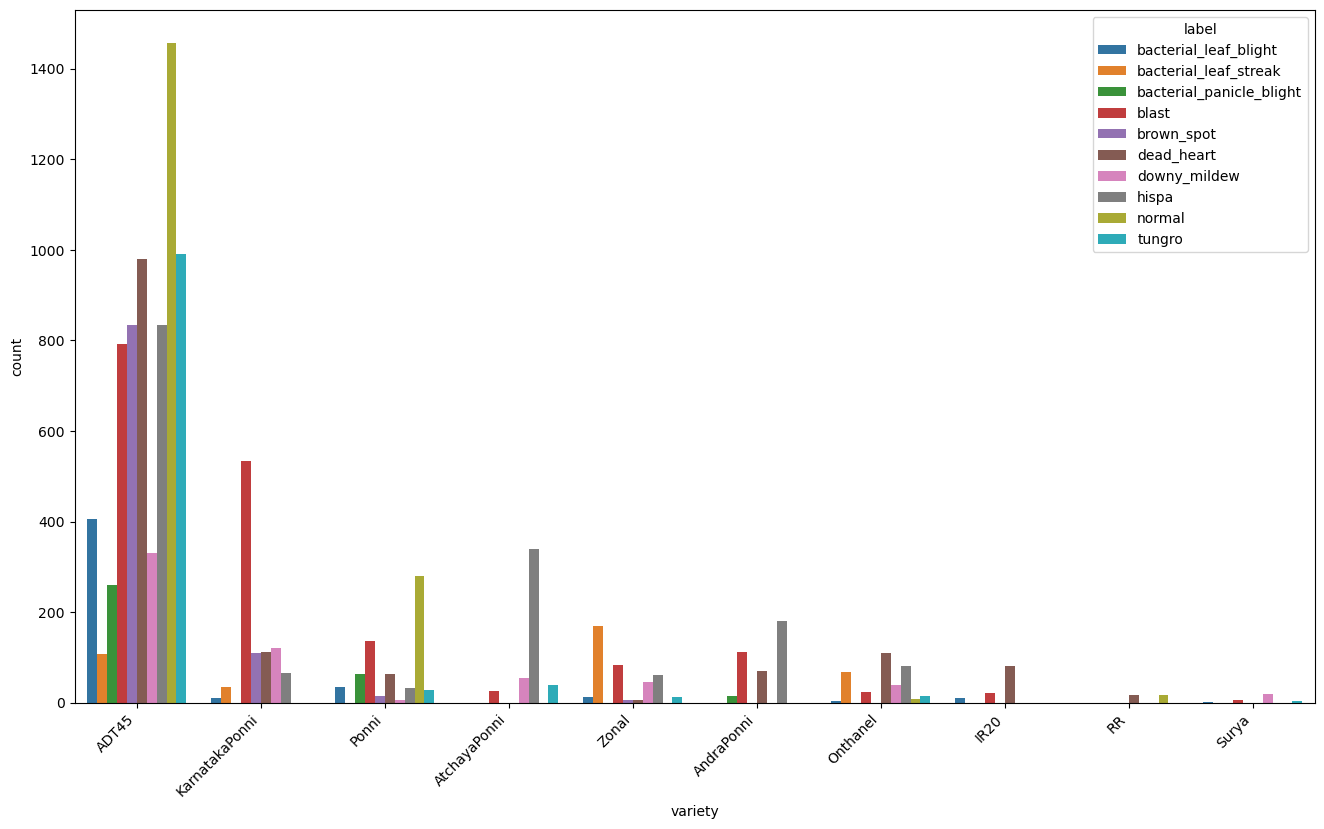

In [188]:
plt.figure(figsize=FIGSIZE)
sns.countplot(data=df, x='variety', hue='label', order = df['variety'].value_counts().index)
plt.xticks(rotation=45, ha='right')
plt.show()

Finally, to demonstrate the contribution of datapoints of `ADT45` to the dataset, most of data comes from only one plant variety, and its distribution could be spot as the majority. By that, further resampling method might be used to improve the performance of trained models later on.

## Image Analysis

### Finding Issues

In [189]:
imagelab = Imagelab(data_path="Dataset/train_images")
imagelab.find_issues()

Reading images from /home/catou/Codes/school/ml/Rice-Plant-Disease-Classification-/Dataset/train_images
Checking for dark, light, odd_aspect_ratio, low_information, exact_duplicates, near_duplicates, blurry, grayscale, odd_size images ...


  0%|          | 0/10407 [00:00<?, ?it/s]

  0%|          | 0/10407 [00:00<?, ?it/s]

Issue checks completed. 388 issues found in the dataset. To see a detailed report of issues found, use imagelab.report().


Apply [CleanVision](https://github.com/cleanlab/cleanvision) on detecting common issues on image dataset, checks are ran to ensure image has normal lighting, sane aspect-ratio, enough information through image size, and if there are exact and almost duplicates in the dataset.

In [190]:
imagelab.info["statistics"]["aspect_ratio"]

count    10407.00
mean         0.75
std          0.00
min          0.75
25%          0.75
50%          0.75
75%          0.75
max          0.75
Name: aspect_ratio, dtype: float64

In [191]:
imagelab.info["statistics"]["size"]

count    1.040700e+04
mean     5.542563e+02
std      1.136923e-13
min      5.542563e+02
25%      5.542563e+02
50%      5.542563e+02
75%      5.542563e+02
max      5.542563e+02
Name: size, dtype: float64

It is found that the dataset has normalized aspect-ratio and image size, consisting of vertically-oriented images of 2:3 aspect ratio - hence the value of 0.75.

In [192]:
imagelab.issue_summary

,issue_type,num_images
0,near_duplicates,242
1,exact_duplicates,146
2,dark,0
3,light,0
4,odd_aspect_ratio,0
5,blurry,0
6,low_information,0
7,odd_size,0
8,grayscale,0


However, the dataset consists of about ~400 duplicates, where it should be visualized to link with metadata, and clean before training begins.

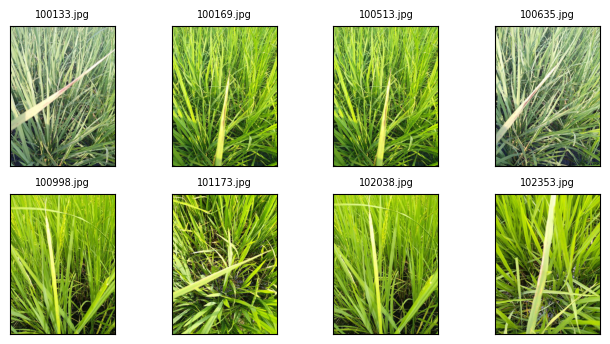

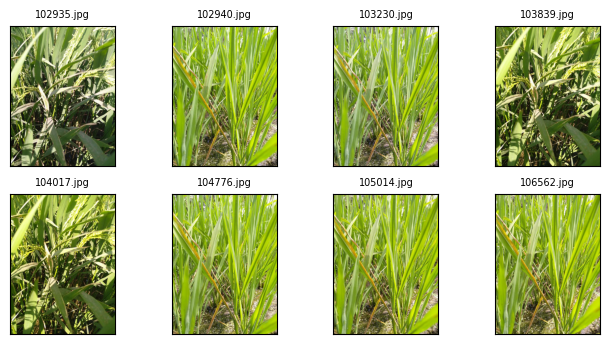

In [193]:
exact_duplicate = imagelab.issues[imagelab.issues["is_exact_duplicates_issue"]].index.tolist()
near_duplicate = imagelab.issues[imagelab.issues["is_near_duplicates_issue"]].index.tolist()
imagelab.visualize(image_files=exact_duplicate[:8])
imagelab.visualize(image_files=near_duplicate[:8])

Upon visualizing some of the exact and near duplicates, same image are spotted to have multiple copies with different file names.

In [195]:
unreliable_sets = []

for set in imagelab.info["exact_duplicates"]["sets"]:
    image_1, image_2 = [set[0].split("/")[-1], set[1].split("/")[-1]]
    meta_1 = df[df["image_id"] == image_1].reset_index().drop(["image_id", "index"], axis=1)
    meta_2 = df[df["image_id"] == image_2].reset_index().drop(["image_id", "index"], axis=1)
    # if comparision has value
    if (not meta_1.compare(meta_2).empty):
        unreliable_sets.append(set)
        print("different metadata")

for set in imagelab.info["near_duplicates"]["sets"]:
    image_1, image_2 = [set[0].split("/")[-1], set[1].split("/")[-1]]
    meta_1 = df[df["image_id"] == image_1].reset_index().drop(["image_id", "index"], axis=1)
    meta_2 = df[df["image_id"] == image_2].reset_index().drop(["image_id", "index"], axis=1)
    # if comparision has value
    if (not meta_1.compare(meta_2).empty):
        unreliable_sets.append(set)
        print("different metadata")

different metadata
different metadata


Ensuring duplicates has the same metadata, comparison is ran on its filename metadata from the dataset. By this, some duplicates has different metadata, so removing the image and its metadata without imputing is possible, by dropping unreliable column that has different metadata while maintaining the same image.

In [196]:
for set in imagelab.info["exact_duplicates"]["sets"]:
    for i in range(len(set)):
        if (i != 0):
            df = df[df["image_id"] != set[i].split("/")[-1]]

for set in imagelab.info["near_duplicates"]["sets"]:
    for i in range(len(set)):
        if (i != 0):
            df = df[df["image_id"] != set[i].split("/")[-1]]

for set in unreliable_sets:
    for i in range(len(set)):
        df = df[df["image_id"] != set[i].split("/")[-1]]

Then, both duplicates and unreliable images are removed from the metadata set.

In [197]:
df.shape

(10201, 4)

With that, the training dataset saw a reduction of about only 2%.

### Colour Patterns

In [238]:
images = []

for i, [image, label] in df[["image_id", "label"]].iterrows():
    image = cv.imread(f"Dataset/train_images/{label}/{image}")
    images.append(image)

In [239]:
colour_distributions = [[], [], []]

for img in images:
    colour_hist = []
    for i, _ in enumerate(("b", "g", "r")):
        colour_distributions[i].append(cv.calcHist([img],[i],None,[256],[0,256]))

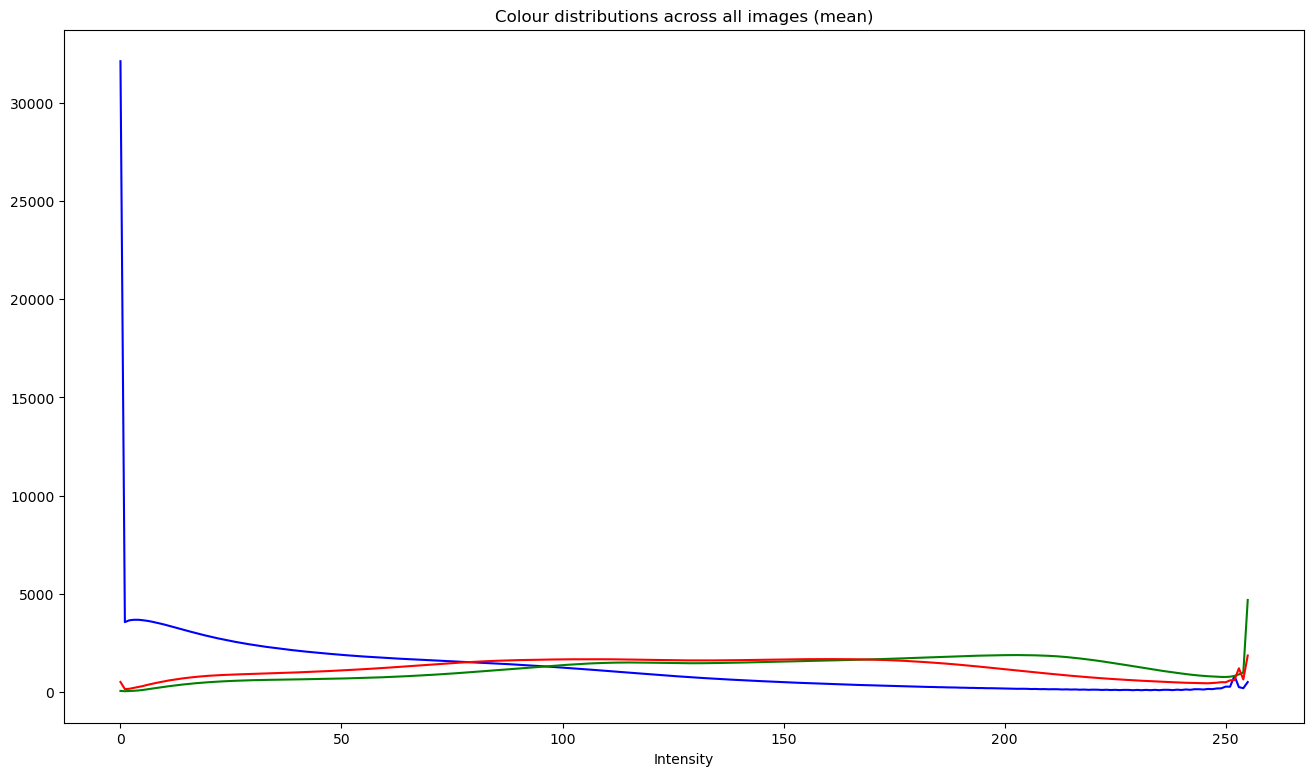

In [240]:
plt.figure(figsize=FIGSIZE)
plt.title("Colour distributions across all images (mean)")
plt.xlabel("Intensity")
plt.plot(np.mean(colour_distributions[0], axis=0), color = "b")
plt.plot(np.mean(colour_distributions[1], axis=0), color = "g")
plt.plot(np.mean(colour_distributions[2], axis=0), color = "r")
plt.show()

Plotting colour distributions across all images, it could be seen that in higher pixel intensity (x > 150), green colourspace has the majority due to image being capture of plants.

In [ ]:
intensity_distrribution = []
for i, [image, label] in df[["image_id", "label"]].iterrows():
    img = cv.imread(f"Dataset/train_images/{label}/{image}")
    intensity_distrribution.append(np.bincount())